In [1]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def tokenize_function(examples,tokenizer):
    result = tokenizer(examples["texte"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

In [4]:
def group_texts(examples,chunk_size):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [5]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [7]:
#datasest
data_files = {"train": "swerick_data_long_train.pkl", "test": "swerick_data_long_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)

DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte', '__index_level_0__'],
        num_rows: 104
    })
    test: Dataset({
        features: ['protocole', 'texte', '__index_level_0__'],
        num_rows: 26
    })
})


In [8]:
tokenized_datasets = swerick_dataset.map(
      lambda examples: tokenize_function(examples, tokenizer), batched=True, remove_columns=["texte", "protocole",'__index_level_0__']
)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 104
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 26
    })
})

In [9]:
chunk_size = 128

In [10]:
lm_datasets = tokenized_datasets.map( lambda examples: group_texts(examples,chunk_size), batched=True) #dataset with chunk
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 57211
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 12561
    })
})

In [11]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)#add the MASK term

In [19]:
data_collator.torch_mask_tokens(lm_datasets["train"])

AttributeError: 'Dataset' object has no attribute 'clone'

In [12]:
batch_size = 64
num_epochs=100
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
print(len(lm_datasets["train"]) // batch_size)
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=False,
    fp16=True,
    logging_steps=logging_steps,
    logging_dir='./logs', 
    num_train_epochs=num_epochs
)

893


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/home/laurinemeier/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [14]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

  0%|          | 0/197 [00:00<?, ?it/s]

>>> Perplexity: 8.08


In [15]:
trainer.train()

  0%|          | 0/89400 [00:00<?, ?it/s]

{'loss': 1.5162, 'grad_norm': 3.8624329566955566, 'learning_rate': 1.9800894854586132e-05, 'epoch': 1.0}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.3014516830444336, 'eval_runtime': 14.5389, 'eval_samples_per_second': 863.958, 'eval_steps_per_second': 13.55, 'epoch': 1.0}
{'loss': 1.3788, 'grad_norm': 3.4182167053222656, 'learning_rate': 1.9601118568232663e-05, 'epoch': 2.0}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.2598940134048462, 'eval_runtime': 15.5803, 'eval_samples_per_second': 806.209, 'eval_steps_per_second': 12.644, 'epoch': 2.0}
{'loss': 1.3223, 'grad_norm': 3.4144227504730225, 'learning_rate': 1.940156599552573e-05, 'epoch': 3.0}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.2364534139633179, 'eval_runtime': 15.8639, 'eval_samples_per_second': 791.797, 'eval_steps_per_second': 12.418, 'epoch': 3.0}
{'loss': 1.2822, 'grad_norm': 3.86775803565979, 'learning_rate': 1.9202013422818792e-05, 'epoch': 4.0}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.2033463716506958, 'eval_runtime': 15.6083, 'eval_samples_per_second': 804.766, 'eval_steps_per_second': 12.622, 'epoch': 4.0}
{'loss': 1.256, 'grad_norm': 3.5989596843719482, 'learning_rate': 1.9002237136465326e-05, 'epoch': 4.99}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.1958333253860474, 'eval_runtime': 15.459, 'eval_samples_per_second': 812.538, 'eval_steps_per_second': 12.743, 'epoch': 5.0}
{'loss': 1.2269, 'grad_norm': 3.8072524070739746, 'learning_rate': 1.880246085011186e-05, 'epoch': 5.99}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.1819102764129639, 'eval_runtime': 14.7531, 'eval_samples_per_second': 851.415, 'eval_steps_per_second': 13.353, 'epoch': 6.0}
{'loss': 1.2096, 'grad_norm': 3.6647942066192627, 'learning_rate': 1.860268456375839e-05, 'epoch': 6.99}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.171553611755371, 'eval_runtime': 15.9789, 'eval_samples_per_second': 786.1, 'eval_steps_per_second': 12.329, 'epoch': 7.0}
{'loss': 1.1902, 'grad_norm': 3.4658522605895996, 'learning_rate': 1.840290827740492e-05, 'epoch': 7.99}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.154314398765564, 'eval_runtime': 15.2978, 'eval_samples_per_second': 821.097, 'eval_steps_per_second': 12.878, 'epoch': 8.0}
{'loss': 1.1739, 'grad_norm': 3.469632625579834, 'learning_rate': 1.8203131991051455e-05, 'epoch': 8.99}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.151384711265564, 'eval_runtime': 15.6689, 'eval_samples_per_second': 801.654, 'eval_steps_per_second': 12.573, 'epoch': 9.0}
{'loss': 1.1639, 'grad_norm': 3.6654460430145264, 'learning_rate': 1.800335570469799e-05, 'epoch': 9.99}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.1459373235702515, 'eval_runtime': 15.6665, 'eval_samples_per_second': 801.773, 'eval_steps_per_second': 12.575, 'epoch': 10.0}
{'loss': 1.1493, 'grad_norm': 3.2639501094818115, 'learning_rate': 1.780357941834452e-05, 'epoch': 10.99}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.1338136196136475, 'eval_runtime': 15.6492, 'eval_samples_per_second': 802.661, 'eval_steps_per_second': 12.589, 'epoch': 11.0}
{'loss': 1.1304, 'grad_norm': 3.730266809463501, 'learning_rate': 1.7604026845637586e-05, 'epoch': 11.99}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.1240859031677246, 'eval_runtime': 15.8643, 'eval_samples_per_second': 791.778, 'eval_steps_per_second': 12.418, 'epoch': 12.0}
{'loss': 1.1258, 'grad_norm': 3.510326862335205, 'learning_rate': 1.7404250559284117e-05, 'epoch': 12.99}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.1327378749847412, 'eval_runtime': 15.5384, 'eval_samples_per_second': 808.383, 'eval_steps_per_second': 12.678, 'epoch': 13.0}
{'loss': 1.1191, 'grad_norm': 3.475118398666382, 'learning_rate': 1.7204697986577183e-05, 'epoch': 13.98}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.1282187700271606, 'eval_runtime': 15.7029, 'eval_samples_per_second': 799.918, 'eval_steps_per_second': 12.545, 'epoch': 14.0}
{'loss': 1.1028, 'grad_norm': 3.444511890411377, 'learning_rate': 1.7004921700223714e-05, 'epoch': 14.98}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.122257947921753, 'eval_runtime': 15.8246, 'eval_samples_per_second': 793.762, 'eval_steps_per_second': 12.449, 'epoch': 15.0}
{'loss': 1.0945, 'grad_norm': 3.8765335083007812, 'learning_rate': 1.6805145413870248e-05, 'epoch': 15.98}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.119004249572754, 'eval_runtime': 15.1478, 'eval_samples_per_second': 829.227, 'eval_steps_per_second': 13.005, 'epoch': 16.0}
{'loss': 1.0804, 'grad_norm': 3.2767763137817383, 'learning_rate': 1.660536912751678e-05, 'epoch': 16.98}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.112023115158081, 'eval_runtime': 15.6312, 'eval_samples_per_second': 803.585, 'eval_steps_per_second': 12.603, 'epoch': 17.0}
{'loss': 1.0727, 'grad_norm': 3.4727914333343506, 'learning_rate': 1.6405592841163313e-05, 'epoch': 17.98}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.10952889919281, 'eval_runtime': 15.6587, 'eval_samples_per_second': 802.171, 'eval_steps_per_second': 12.581, 'epoch': 18.0}
{'loss': 1.0646, 'grad_norm': 3.5295567512512207, 'learning_rate': 1.6205816554809847e-05, 'epoch': 18.98}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.1081441640853882, 'eval_runtime': 15.7516, 'eval_samples_per_second': 797.442, 'eval_steps_per_second': 12.507, 'epoch': 19.0}
{'loss': 1.0673, 'grad_norm': 3.5527501106262207, 'learning_rate': 1.6006040268456378e-05, 'epoch': 19.98}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.1010233163833618, 'eval_runtime': 15.7839, 'eval_samples_per_second': 795.81, 'eval_steps_per_second': 12.481, 'epoch': 20.0}
{'loss': 1.0538, 'grad_norm': 3.492243528366089, 'learning_rate': 1.580626398210291e-05, 'epoch': 20.98}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.094595193862915, 'eval_runtime': 15.8668, 'eval_samples_per_second': 791.654, 'eval_steps_per_second': 12.416, 'epoch': 21.0}
{'loss': 1.0444, 'grad_norm': 3.5893216133117676, 'learning_rate': 1.5606711409395975e-05, 'epoch': 21.98}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0969840288162231, 'eval_runtime': 15.7763, 'eval_samples_per_second': 796.194, 'eval_steps_per_second': 12.487, 'epoch': 22.0}
{'loss': 1.039, 'grad_norm': 3.5538976192474365, 'learning_rate': 1.540715883668904e-05, 'epoch': 22.97}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0996769666671753, 'eval_runtime': 15.7743, 'eval_samples_per_second': 796.294, 'eval_steps_per_second': 12.489, 'epoch': 23.0}
{'loss': 1.0299, 'grad_norm': 3.4402246475219727, 'learning_rate': 1.5207382550335571e-05, 'epoch': 23.97}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0921745300292969, 'eval_runtime': 15.955, 'eval_samples_per_second': 787.279, 'eval_steps_per_second': 12.347, 'epoch': 24.0}
{'loss': 1.0245, 'grad_norm': 3.2553396224975586, 'learning_rate': 1.5007829977628636e-05, 'epoch': 24.97}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0944926738739014, 'eval_runtime': 15.8708, 'eval_samples_per_second': 791.452, 'eval_steps_per_second': 12.413, 'epoch': 25.0}
{'loss': 1.0167, 'grad_norm': 3.4961304664611816, 'learning_rate': 1.4808053691275168e-05, 'epoch': 25.97}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0915813446044922, 'eval_runtime': 15.7057, 'eval_samples_per_second': 799.771, 'eval_steps_per_second': 12.543, 'epoch': 26.0}
{'loss': 1.0113, 'grad_norm': 3.3843541145324707, 'learning_rate': 1.4608277404921702e-05, 'epoch': 26.97}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0884169340133667, 'eval_runtime': 15.3608, 'eval_samples_per_second': 817.731, 'eval_steps_per_second': 12.825, 'epoch': 27.0}
{'loss': 1.0072, 'grad_norm': 4.0111236572265625, 'learning_rate': 1.4408501118568235e-05, 'epoch': 27.97}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0863343477249146, 'eval_runtime': 15.183, 'eval_samples_per_second': 827.304, 'eval_steps_per_second': 12.975, 'epoch': 28.0}
{'loss': 1.004, 'grad_norm': 3.327134132385254, 'learning_rate': 1.4208724832214767e-05, 'epoch': 28.97}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0896085500717163, 'eval_runtime': 15.1893, 'eval_samples_per_second': 826.964, 'eval_steps_per_second': 12.97, 'epoch': 29.0}
{'loss': 0.997, 'grad_norm': 3.2905890941619873, 'learning_rate': 1.400917225950783e-05, 'epoch': 29.97}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0861749649047852, 'eval_runtime': 15.2297, 'eval_samples_per_second': 824.77, 'eval_steps_per_second': 12.935, 'epoch': 30.0}
{'loss': 0.9944, 'grad_norm': 3.4232966899871826, 'learning_rate': 1.3809619686800896e-05, 'epoch': 30.97}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0712581872940063, 'eval_runtime': 17.359, 'eval_samples_per_second': 723.601, 'eval_steps_per_second': 11.349, 'epoch': 31.0}
{'loss': 0.9866, 'grad_norm': 3.476167678833008, 'learning_rate': 1.3609843400447429e-05, 'epoch': 31.96}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0830358266830444, 'eval_runtime': 17.1595, 'eval_samples_per_second': 732.013, 'eval_steps_per_second': 11.48, 'epoch': 32.0}
{'loss': 0.9783, 'grad_norm': 3.333082437515259, 'learning_rate': 1.3410067114093961e-05, 'epoch': 32.96}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0804238319396973, 'eval_runtime': 18.6343, 'eval_samples_per_second': 674.08, 'eval_steps_per_second': 10.572, 'epoch': 33.0}
{'loss': 0.9779, 'grad_norm': 3.7847557067871094, 'learning_rate': 1.3210514541387026e-05, 'epoch': 33.96}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.088297724723816, 'eval_runtime': 18.2657, 'eval_samples_per_second': 687.683, 'eval_steps_per_second': 10.785, 'epoch': 34.0}
{'loss': 0.9704, 'grad_norm': 3.4438958168029785, 'learning_rate': 1.3010738255033556e-05, 'epoch': 34.96}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0768929719924927, 'eval_runtime': 17.0678, 'eval_samples_per_second': 735.948, 'eval_steps_per_second': 11.542, 'epoch': 35.0}
{'loss': 0.9646, 'grad_norm': 3.4518306255340576, 'learning_rate': 1.2811185682326624e-05, 'epoch': 35.96}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0770187377929688, 'eval_runtime': 17.3633, 'eval_samples_per_second': 723.423, 'eval_steps_per_second': 11.346, 'epoch': 36.0}
{'loss': 0.9604, 'grad_norm': 3.5462496280670166, 'learning_rate': 1.2611409395973155e-05, 'epoch': 36.96}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.073901891708374, 'eval_runtime': 17.5313, 'eval_samples_per_second': 716.489, 'eval_steps_per_second': 11.237, 'epoch': 37.0}
{'loss': 0.9599, 'grad_norm': 3.41680645942688, 'learning_rate': 1.2411633109619687e-05, 'epoch': 37.96}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0702800750732422, 'eval_runtime': 17.225, 'eval_samples_per_second': 729.231, 'eval_steps_per_second': 11.437, 'epoch': 38.0}
{'loss': 0.9512, 'grad_norm': 3.3438313007354736, 'learning_rate': 1.2212080536912753e-05, 'epoch': 38.96}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0692005157470703, 'eval_runtime': 16.8128, 'eval_samples_per_second': 747.11, 'eval_steps_per_second': 11.717, 'epoch': 39.0}
{'loss': 0.9504, 'grad_norm': 3.41239070892334, 'learning_rate': 1.2012527964205818e-05, 'epoch': 39.96}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0678672790527344, 'eval_runtime': 17.5904, 'eval_samples_per_second': 714.083, 'eval_steps_per_second': 11.199, 'epoch': 40.0}
{'loss': 0.9436, 'grad_norm': 3.4849088191986084, 'learning_rate': 1.181275167785235e-05, 'epoch': 40.95}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0698689222335815, 'eval_runtime': 15.1608, 'eval_samples_per_second': 828.519, 'eval_steps_per_second': 12.994, 'epoch': 41.0}
{'loss': 0.9424, 'grad_norm': 3.5842654705047607, 'learning_rate': 1.1612975391498881e-05, 'epoch': 41.95}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.061751127243042, 'eval_runtime': 15.2207, 'eval_samples_per_second': 825.258, 'eval_steps_per_second': 12.943, 'epoch': 42.0}
{'loss': 0.9382, 'grad_norm': 3.409249782562256, 'learning_rate': 1.1413199105145413e-05, 'epoch': 42.95}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0682332515716553, 'eval_runtime': 15.1706, 'eval_samples_per_second': 827.982, 'eval_steps_per_second': 12.986, 'epoch': 43.0}
{'loss': 0.9313, 'grad_norm': 3.6652352809906006, 'learning_rate': 1.121364653243848e-05, 'epoch': 43.95}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0627708435058594, 'eval_runtime': 15.2673, 'eval_samples_per_second': 822.737, 'eval_steps_per_second': 12.903, 'epoch': 44.0}
{'loss': 0.9324, 'grad_norm': 3.6142029762268066, 'learning_rate': 1.1013870246085012e-05, 'epoch': 44.95}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0612164735794067, 'eval_runtime': 15.1877, 'eval_samples_per_second': 827.048, 'eval_steps_per_second': 12.971, 'epoch': 45.0}
{'loss': 0.927, 'grad_norm': 3.4166502952575684, 'learning_rate': 1.0814093959731544e-05, 'epoch': 45.95}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.069244384765625, 'eval_runtime': 16.004, 'eval_samples_per_second': 784.866, 'eval_steps_per_second': 12.309, 'epoch': 46.0}
{'loss': 0.9243, 'grad_norm': 3.7056493759155273, 'learning_rate': 1.0614317673378077e-05, 'epoch': 46.95}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.060124397277832, 'eval_runtime': 15.7572, 'eval_samples_per_second': 797.159, 'eval_steps_per_second': 12.502, 'epoch': 47.0}
{'loss': 0.9226, 'grad_norm': 3.3595762252807617, 'learning_rate': 1.041454138702461e-05, 'epoch': 47.95}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0636483430862427, 'eval_runtime': 15.7621, 'eval_samples_per_second': 796.91, 'eval_steps_per_second': 12.498, 'epoch': 48.0}
{'loss': 0.9142, 'grad_norm': 3.5151588916778564, 'learning_rate': 1.0214765100671142e-05, 'epoch': 48.95}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.070021629333496, 'eval_runtime': 15.8762, 'eval_samples_per_second': 791.184, 'eval_steps_per_second': 12.409, 'epoch': 49.0}
{'loss': 0.9131, 'grad_norm': 3.5589022636413574, 'learning_rate': 1.0014988814317674e-05, 'epoch': 49.94}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0611021518707275, 'eval_runtime': 15.7401, 'eval_samples_per_second': 798.023, 'eval_steps_per_second': 12.516, 'epoch': 50.0}
{'loss': 0.9103, 'grad_norm': 3.523900270462036, 'learning_rate': 9.81543624161074e-06, 'epoch': 50.94}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0676841735839844, 'eval_runtime': 15.9222, 'eval_samples_per_second': 788.898, 'eval_steps_per_second': 12.373, 'epoch': 51.0}
{'loss': 0.9061, 'grad_norm': 3.4619133472442627, 'learning_rate': 9.61565995525727e-06, 'epoch': 51.94}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0606430768966675, 'eval_runtime': 15.9874, 'eval_samples_per_second': 785.682, 'eval_steps_per_second': 12.322, 'epoch': 52.0}
{'loss': 0.9042, 'grad_norm': 3.6621203422546387, 'learning_rate': 9.416107382550337e-06, 'epoch': 52.94}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0611517429351807, 'eval_runtime': 15.6612, 'eval_samples_per_second': 802.046, 'eval_steps_per_second': 12.579, 'epoch': 53.0}
{'loss': 0.8994, 'grad_norm': 3.507965087890625, 'learning_rate': 9.21633109619687e-06, 'epoch': 53.94}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0568971633911133, 'eval_runtime': 15.8255, 'eval_samples_per_second': 793.72, 'eval_steps_per_second': 12.448, 'epoch': 54.0}
{'loss': 0.8968, 'grad_norm': 3.52774715423584, 'learning_rate': 9.0165548098434e-06, 'epoch': 54.94}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0628563165664673, 'eval_runtime': 15.7461, 'eval_samples_per_second': 797.719, 'eval_steps_per_second': 12.511, 'epoch': 55.0}
{'loss': 0.8935, 'grad_norm': 3.279675245285034, 'learning_rate': 8.817002237136466e-06, 'epoch': 55.94}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.064560890197754, 'eval_runtime': 15.7583, 'eval_samples_per_second': 797.103, 'eval_steps_per_second': 12.501, 'epoch': 56.0}
{'loss': 0.8923, 'grad_norm': 3.7270445823669434, 'learning_rate': 8.617225950782999e-06, 'epoch': 56.94}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.058787226676941, 'eval_runtime': 15.8188, 'eval_samples_per_second': 794.055, 'eval_steps_per_second': 12.454, 'epoch': 57.0}
{'loss': 0.8882, 'grad_norm': 3.623413324356079, 'learning_rate': 8.417449664429531e-06, 'epoch': 57.94}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0501660108566284, 'eval_runtime': 15.7309, 'eval_samples_per_second': 798.494, 'eval_steps_per_second': 12.523, 'epoch': 58.0}
{'loss': 0.8858, 'grad_norm': 3.5527970790863037, 'learning_rate': 8.217897091722596e-06, 'epoch': 58.93}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.07090163230896, 'eval_runtime': 15.8024, 'eval_samples_per_second': 794.88, 'eval_steps_per_second': 12.466, 'epoch': 59.0}
{'loss': 0.8838, 'grad_norm': 3.529209613800049, 'learning_rate': 8.018120805369128e-06, 'epoch': 59.93}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.059162974357605, 'eval_runtime': 15.6859, 'eval_samples_per_second': 800.784, 'eval_steps_per_second': 12.559, 'epoch': 60.0}
{'loss': 0.8847, 'grad_norm': 3.6943252086639404, 'learning_rate': 7.81834451901566e-06, 'epoch': 60.93}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.056896448135376, 'eval_runtime': 15.7111, 'eval_samples_per_second': 799.5, 'eval_steps_per_second': 12.539, 'epoch': 61.0}
{'loss': 0.8797, 'grad_norm': 3.3928444385528564, 'learning_rate': 7.618568232662194e-06, 'epoch': 61.93}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0566972494125366, 'eval_runtime': 15.7552, 'eval_samples_per_second': 797.263, 'eval_steps_per_second': 12.504, 'epoch': 62.0}
{'loss': 0.8744, 'grad_norm': 3.2614152431488037, 'learning_rate': 7.419015659955257e-06, 'epoch': 62.93}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0611323118209839, 'eval_runtime': 16.0047, 'eval_samples_per_second': 784.831, 'eval_steps_per_second': 12.309, 'epoch': 63.0}
{'loss': 0.8722, 'grad_norm': 3.267360210418701, 'learning_rate': 7.2192393736017905e-06, 'epoch': 63.93}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0562127828598022, 'eval_runtime': 15.8587, 'eval_samples_per_second': 792.056, 'eval_steps_per_second': 12.422, 'epoch': 64.0}
{'loss': 0.8738, 'grad_norm': 3.4431064128875732, 'learning_rate': 7.019463087248323e-06, 'epoch': 64.93}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0529993772506714, 'eval_runtime': 15.8725, 'eval_samples_per_second': 791.37, 'eval_steps_per_second': 12.411, 'epoch': 65.0}
{'loss': 0.8652, 'grad_norm': 3.4321444034576416, 'learning_rate': 6.819686800894854e-06, 'epoch': 65.93}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0594902038574219, 'eval_runtime': 15.3774, 'eval_samples_per_second': 816.846, 'eval_steps_per_second': 12.811, 'epoch': 66.0}
{'loss': 0.8664, 'grad_norm': 3.2074716091156006, 'learning_rate': 6.619910514541388e-06, 'epoch': 66.93}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.05408775806427, 'eval_runtime': 15.1285, 'eval_samples_per_second': 830.289, 'eval_steps_per_second': 13.022, 'epoch': 67.0}
{'loss': 0.8668, 'grad_norm': 3.604853868484497, 'learning_rate': 6.42013422818792e-06, 'epoch': 67.92}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0532541275024414, 'eval_runtime': 15.2216, 'eval_samples_per_second': 825.21, 'eval_steps_per_second': 12.942, 'epoch': 68.0}
{'loss': 0.8615, 'grad_norm': 3.7875380516052246, 'learning_rate': 6.220581655480985e-06, 'epoch': 68.92}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0526759624481201, 'eval_runtime': 15.5171, 'eval_samples_per_second': 809.493, 'eval_steps_per_second': 12.696, 'epoch': 69.0}
{'loss': 0.8611, 'grad_norm': 3.4419100284576416, 'learning_rate': 6.020805369127517e-06, 'epoch': 69.92}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0518825054168701, 'eval_runtime': 15.15, 'eval_samples_per_second': 829.106, 'eval_steps_per_second': 13.003, 'epoch': 70.0}
{'loss': 0.8571, 'grad_norm': 3.647876024246216, 'learning_rate': 5.82102908277405e-06, 'epoch': 70.92}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0601518154144287, 'eval_runtime': 15.5959, 'eval_samples_per_second': 805.405, 'eval_steps_per_second': 12.632, 'epoch': 71.0}
{'loss': 0.8583, 'grad_norm': 3.5972979068756104, 'learning_rate': 5.621476510067115e-06, 'epoch': 71.92}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.050915002822876, 'eval_runtime': 15.6607, 'eval_samples_per_second': 802.073, 'eval_steps_per_second': 12.579, 'epoch': 72.0}
{'loss': 0.8533, 'grad_norm': 3.246422529220581, 'learning_rate': 5.421923937360179e-06, 'epoch': 72.92}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0591723918914795, 'eval_runtime': 15.648, 'eval_samples_per_second': 802.724, 'eval_steps_per_second': 12.589, 'epoch': 73.0}
{'loss': 0.8529, 'grad_norm': 3.3887996673583984, 'learning_rate': 5.2223713646532446e-06, 'epoch': 73.92}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0468579530715942, 'eval_runtime': 15.3532, 'eval_samples_per_second': 818.133, 'eval_steps_per_second': 12.831, 'epoch': 74.0}
{'loss': 0.8514, 'grad_norm': 3.2083699703216553, 'learning_rate': 5.022595078299777e-06, 'epoch': 74.92}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0576030015945435, 'eval_runtime': 15.5, 'eval_samples_per_second': 810.389, 'eval_steps_per_second': 12.71, 'epoch': 75.0}
{'loss': 0.8484, 'grad_norm': 3.281240463256836, 'learning_rate': 4.822818791946309e-06, 'epoch': 75.91}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0499157905578613, 'eval_runtime': 15.206, 'eval_samples_per_second': 826.057, 'eval_steps_per_second': 12.955, 'epoch': 76.0}
{'loss': 0.8514, 'grad_norm': 3.2546470165252686, 'learning_rate': 4.623042505592842e-06, 'epoch': 76.91}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0452598333358765, 'eval_runtime': 15.2162, 'eval_samples_per_second': 825.501, 'eval_steps_per_second': 12.947, 'epoch': 77.0}
{'loss': 0.8487, 'grad_norm': 3.310844659805298, 'learning_rate': 4.423266219239374e-06, 'epoch': 77.91}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0497597455978394, 'eval_runtime': 15.4977, 'eval_samples_per_second': 810.509, 'eval_steps_per_second': 12.712, 'epoch': 78.0}
{'loss': 0.8452, 'grad_norm': 3.679917335510254, 'learning_rate': 4.2234899328859065e-06, 'epoch': 78.91}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.058700442314148, 'eval_runtime': 16.0215, 'eval_samples_per_second': 784.011, 'eval_steps_per_second': 12.296, 'epoch': 79.0}
{'loss': 0.8418, 'grad_norm': 3.1319069862365723, 'learning_rate': 4.023713646532439e-06, 'epoch': 79.91}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.047802209854126, 'eval_runtime': 15.351, 'eval_samples_per_second': 818.251, 'eval_steps_per_second': 12.833, 'epoch': 80.0}
{'loss': 0.8379, 'grad_norm': 3.5840086936950684, 'learning_rate': 3.823937360178971e-06, 'epoch': 80.91}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0508497953414917, 'eval_runtime': 16.2138, 'eval_samples_per_second': 774.712, 'eval_steps_per_second': 12.15, 'epoch': 81.0}
{'loss': 0.8391, 'grad_norm': 3.3530008792877197, 'learning_rate': 3.624832214765101e-06, 'epoch': 81.91}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0459935665130615, 'eval_runtime': 15.9206, 'eval_samples_per_second': 788.977, 'eval_steps_per_second': 12.374, 'epoch': 82.0}
{'loss': 0.8382, 'grad_norm': 3.687452793121338, 'learning_rate': 3.4250559284116337e-06, 'epoch': 82.91}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0536502599716187, 'eval_runtime': 15.9156, 'eval_samples_per_second': 789.224, 'eval_steps_per_second': 12.378, 'epoch': 83.0}
{'loss': 0.8362, 'grad_norm': 3.3034451007843018, 'learning_rate': 3.2255033557046982e-06, 'epoch': 83.91}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0454484224319458, 'eval_runtime': 15.6937, 'eval_samples_per_second': 800.386, 'eval_steps_per_second': 12.553, 'epoch': 84.0}
{'loss': 0.8336, 'grad_norm': 3.4156386852264404, 'learning_rate': 3.025727069351231e-06, 'epoch': 84.9}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0518126487731934, 'eval_runtime': 16.0381, 'eval_samples_per_second': 783.195, 'eval_steps_per_second': 12.283, 'epoch': 85.0}
{'loss': 0.8353, 'grad_norm': 3.5490498542785645, 'learning_rate': 2.825950782997763e-06, 'epoch': 85.9}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0441044569015503, 'eval_runtime': 15.8924, 'eval_samples_per_second': 790.377, 'eval_steps_per_second': 12.396, 'epoch': 86.0}
{'loss': 0.8327, 'grad_norm': 3.6911771297454834, 'learning_rate': 2.6261744966442954e-06, 'epoch': 86.9}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0518654584884644, 'eval_runtime': 15.8381, 'eval_samples_per_second': 793.088, 'eval_steps_per_second': 12.438, 'epoch': 87.0}
{'loss': 0.833, 'grad_norm': 3.6403768062591553, 'learning_rate': 2.4263982102908277e-06, 'epoch': 87.9}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0397191047668457, 'eval_runtime': 15.8376, 'eval_samples_per_second': 793.114, 'eval_steps_per_second': 12.439, 'epoch': 88.0}
{'loss': 0.8294, 'grad_norm': 3.436286211013794, 'learning_rate': 2.2268456375838927e-06, 'epoch': 88.9}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0518535375595093, 'eval_runtime': 15.9414, 'eval_samples_per_second': 787.949, 'eval_steps_per_second': 12.358, 'epoch': 89.0}
{'loss': 0.828, 'grad_norm': 3.4496359825134277, 'learning_rate': 2.027069351230425e-06, 'epoch': 89.9}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.045654058456421, 'eval_runtime': 15.9321, 'eval_samples_per_second': 788.41, 'eval_steps_per_second': 12.365, 'epoch': 90.0}
{'loss': 0.8288, 'grad_norm': 3.5670719146728516, 'learning_rate': 1.82751677852349e-06, 'epoch': 90.9}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0507889986038208, 'eval_runtime': 15.7996, 'eval_samples_per_second': 795.018, 'eval_steps_per_second': 12.469, 'epoch': 91.0}
{'loss': 0.8296, 'grad_norm': 3.3892650604248047, 'learning_rate': 1.6277404921700224e-06, 'epoch': 91.9}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.058485746383667, 'eval_runtime': 15.872, 'eval_samples_per_second': 791.394, 'eval_steps_per_second': 12.412, 'epoch': 92.0}
{'loss': 0.825, 'grad_norm': 3.494529962539673, 'learning_rate': 1.427964205816555e-06, 'epoch': 92.9}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0432021617889404, 'eval_runtime': 15.9855, 'eval_samples_per_second': 785.777, 'eval_steps_per_second': 12.324, 'epoch': 93.0}
{'loss': 0.8287, 'grad_norm': 3.638763666152954, 'learning_rate': 1.2281879194630874e-06, 'epoch': 93.89}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0505285263061523, 'eval_runtime': 15.8797, 'eval_samples_per_second': 791.008, 'eval_steps_per_second': 12.406, 'epoch': 94.0}
{'loss': 0.8246, 'grad_norm': 3.2618186473846436, 'learning_rate': 1.0284116331096198e-06, 'epoch': 94.89}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0501470565795898, 'eval_runtime': 15.8776, 'eval_samples_per_second': 791.117, 'eval_steps_per_second': 12.407, 'epoch': 95.0}
{'loss': 0.8246, 'grad_norm': 3.699934720993042, 'learning_rate': 8.286353467561522e-07, 'epoch': 95.89}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0429985523223877, 'eval_runtime': 15.7929, 'eval_samples_per_second': 795.359, 'eval_steps_per_second': 12.474, 'epoch': 96.0}
{'loss': 0.829, 'grad_norm': 3.499248743057251, 'learning_rate': 6.288590604026846e-07, 'epoch': 96.89}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0453307628631592, 'eval_runtime': 15.9178, 'eval_samples_per_second': 789.115, 'eval_steps_per_second': 12.376, 'epoch': 97.0}
{'loss': 0.8265, 'grad_norm': 3.5311219692230225, 'learning_rate': 4.2908277404921704e-07, 'epoch': 97.89}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0449460744857788, 'eval_runtime': 16.0457, 'eval_samples_per_second': 782.828, 'eval_steps_per_second': 12.277, 'epoch': 98.0}
{'loss': 0.8241, 'grad_norm': 3.4797680377960205, 'learning_rate': 2.297539149888143e-07, 'epoch': 98.89}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.045609474182129, 'eval_runtime': 15.9596, 'eval_samples_per_second': 787.05, 'eval_steps_per_second': 12.344, 'epoch': 99.0}
{'loss': 0.8264, 'grad_norm': 3.713367223739624, 'learning_rate': 3.0201342281879194e-08, 'epoch': 99.89}


  0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': 1.0460364818572998, 'eval_runtime': 15.8911, 'eval_samples_per_second': 790.442, 'eval_steps_per_second': 12.397, 'epoch': 100.0}
{'train_runtime': 20691.924, 'train_samples_per_second': 276.49, 'train_steps_per_second': 4.321, 'train_loss': 0.9570799721327404, 'epoch': 100.0}


TrainOutput(global_step=89400, training_loss=0.9570799721327404, metrics={'train_runtime': 20691.924, 'train_samples_per_second': 276.49, 'train_steps_per_second': 4.321, 'train_loss': 0.9570799721327404, 'epoch': 100.0})

In [20]:
file_path = "finetuning_hugging.pth"
model.save_pretrained("finetuning_trainer")
tokenizer.save_pretrained("finetuning_trainer")

('finetuning_trainer/tokenizer_config.json',
 'finetuning_trainer/special_tokens_map.json',
 'finetuning_trainer/vocab.txt',
 'finetuning_trainer/added_tokens.json',
 'finetuning_trainer/tokenizer.json')

<class 'list'>
201


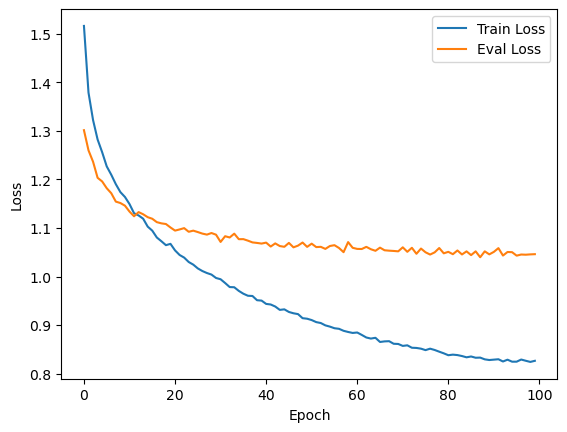

In [17]:
# Get the training and validation losses
print(type(trainer.state.log_history))
print(len(trainer.state.log_history))
train_losses=[]
test_losses=[]
for i in range(len(trainer.state.log_history)//2):
    train_losses.append(trainer.state.log_history[2*i]["loss"])
    test_losses.append(trainer.state.log_history[2*i+1]["eval_loss"])
#eval_losses = trainer.state.log_history["eval_loss"]

#print(train_losses)

# Plot the losses
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
import pickle

file_name = "losses_hugging.pkl"

with open(file_name, 'wb') as f:
    pickle.dump({'losses_train': train_losses, 'losses_test': test_losses}, f)

In [ ]:
print(swerick_dataset)